In [51]:
import os
import numpy as np
import librosa
import time
import IPython
import torch

SAMPLE_RATE = 44100 # sample rate
BATCH_SIZE = 128
SEGMENT_SIZE = 8 # seconds
CLIP = 0 # remove CLIP amount of seconds from start of the song and from end of the song
SAMPLES_PER_SEGMENT = int(SEGMENT_SIZE * SAMPLE_RATE)
NUM_EPOCHS = 64

# Spectrogram params
N_MELS = 128  # Number of Mel bands
HOP_LENGTH = 512  # Number of samples between successive frames

bands = os.listdir("songs\\")
dataset_structure = {}
for band in bands:
    songs = os.listdir(f"songs\\{band}\\")
    dataset_structure[band] = songs

# Create a mapping from band names to indices (labels)
band_to_idx = {band: idx for idx, band in enumerate(bands)}
idx_to_band = {idx: band for band, idx in band_to_idx.items()}

print(f'Number of bands: {len(bands)}')
print(f'Total number of songs: {sum(len(songs) for songs in dataset_structure.values())}')

Number of bands: 9
Total number of songs: 1188


<h2>Memory efficient dataloader</h2>

In [2]:
# get song file names
def get_dataset(folder='songs'):
    dataset = {}
    for band in bands:
        if band not in dataset:dataset[band] = []
        songs = os.listdir(f"{folder}\\{band}\\")
        dataset[band] = songs
    return dataset

train_dataset = get_dataset()
test_dataset = get_dataset("songs test")

In [3]:
def generate_random_set_MEMORY_EFFICIENT(n, segment_length, dataset, folder="songs"):
    segments = []
    labels = []
    bands = list(dataset_structure.keys())
    for i in range(n):
        chosen_band = np.random.choice(bands)
        chosen_song_file = np.random.choice(dataset[chosen_band])

        # Load the audio file
        y, sr = librosa.load(f"{folder}\\{chosen_band}\\{chosen_song_file}", sr=SAMPLE_RATE)
        # Calculate the number of samples per segment
        samples_per_segment = int(segment_length * sr)

        # Calculate the number of segments that can fit in the song
        total_samples = len(y)
        max_segments = total_samples // samples_per_segment

        #assert total_samples > samples_per_segment, f"{chosen_song_file}: song too short for this segment length"
        if not (total_samples > samples_per_segment):
            print(f"{chosen_song_file}: song too short for this segment length")
            continue

        # Randomly choose a starting point for the segment
        start_sample = np.random.randint(sr*CLIP, total_samples - samples_per_segment-sr*CLIP)
        end_sample = start_sample + samples_per_segment
        segment = y[start_sample:end_sample]
        # Normalize the audio (optional)
        segment = librosa.util.normalize(segment)

        # Convert segment to PyTorch tensor
        #segment_tensor = torch.tensor(segment, dtype=torch.float32)

        # Ensure the shape is (1, samples_per_segment) to represent a mono channel
        #segment_tensor = segment_tensor.unsqueeze(0)  # Add channel dimension (1 for mono)

        mel_spec = librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Convert to PyTorch tensor and add a channel dimension
        segment_tensor = torch.tensor(mel_spec_db, dtype=torch.float32).unsqueeze(0)

        segments.append(segment_tensor)
        labels.append(band_to_idx[chosen_band])


    return torch.stack(segments), torch.tensor(labels, dtype=torch.long)

#validation_set, validation_labels = generate_random_set_MEMORY_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, test_dataset, folder="songs test")


<h2>Time efficient dataloader</h2>

In [4]:
# Preload all the songs
def get_dataset(folder='songs'):
    dataset = {}
    for band in bands:
        if band not in dataset:dataset[band] = []
        songs = os.listdir(f"{folder}\\{band}\\")
        for song in songs:
            try:
                y, sr = librosa.load(f"{folder}\\{band}\\{song}", sr=SAMPLE_RATE)
            except:
                print(f"ERROR: {song}")
                continue

            total_samples = len(y)
            if(total_samples < SAMPLES_PER_SEGMENT):
                print(f"{song}: song too short for this segment length")
                continue
            #assert total_samples > samples_per_segment, f"{song}:song too short for this segment length"

            dataset[band].append(y)
    return dataset

train_dataset = get_dataset()
test_dataset = get_dataset("songs test")

ABBA rareIn The Arms Of Rosalita 19 sec Demo.mp3: song too short for this segment length
The Beatles Recovered Band - Her Majesty.mp3: song too short for this segment length


In [ ]:
def generate_random_set_TIME_EFFICIENT(n, segment_length, dataset):
    segments = []
    labels = []
    bands = list(dataset.keys())
    for i in range(n):
        chosen_band = np.random.choice(bands)
        song_index = np.random.choice(len(dataset[chosen_band]))
        y = dataset[chosen_band][song_index]
        # Load the audio file
        #y, sr = librosa.load(f"songs\\{chosen_band}\\{chosen_song_file}", sr=SAMPLE_RATE)

        # Calculate the number of samples per segment
        #samples_per_segment = int(segment_length * SAMPLE_RATE)

        # Calculate the number of segments that can fit in the song
        total_samples = len(y)

        # Randomly choose a starting point for the segment
        start_sample = np.random.randint(SAMPLE_RATE*CLIP, total_samples - SAMPLES_PER_SEGMENT-SAMPLE_RATE*CLIP)
        end_sample = start_sample + SAMPLES_PER_SEGMENT
        segment = y[start_sample:end_sample]
        # Normalize the audio (optional)
        segment = librosa.util.normalize(segment)

        # # Convert segment to PyTorch tensor
        # segment_tensor = torch.tensor(segment, dtype=torch.float32)

        # # Ensure the shape is (1, samples_per_segment) to represent a mono channel
        # segment_tensor = segment_tensor.unsqueeze(0)  # Add channel dimension (1 for mono)

        mel_spec = librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Convert to PyTorch tensor and add a channel dimension
        segment_tensor = torch.tensor(mel_spec_db, dtype=torch.float32).unsqueeze(0)

        segments.append(segment_tensor)
        labels.append(band_to_idx[chosen_band])


    return torch.stack(segments), torch.tensor(labels, dtype=torch.long)

train_set_x, train_set_labels = generate_random_TIME_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, train_dataset)
test_set_x, test_set_labels = generate_random_TIME_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, test_dataset)

<h2>Trivial solution</h2>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedBandClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedBandClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        residual = x
        x = F.relu(self.bn4(self.conv4(x)))
        x = x + residual
        x = self.dropout4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

<h2>Resnet solution</h2>

In [4]:
import torch.nn as nn
from torchvision import models

class BandClassifierResNet50(nn.Module):
    def __init__(self, num_classes):
        super(BandClassifierResNet50, self).__init__()
        # Load the pretrained ResNet50 model
        self.model = models.resnet50(pretrained=True)
        
        # Modify the first convolutional layer to accept single-channel input
        self.model.conv1 = nn.Conv2d(
            in_channels=1,  # Change to 1 channel
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        
        # Remove the last fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Use identity to bypass the original fc layer
        
        # Define new MLP layers
        self.fc_layers = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.model(x)  # Extract features using ResNet50 backbone
        x = self.fc_layers(x)  # Pass through the new MLP layers
        return x

C:\Users\theal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = BandClassifierResNet50(len(bands))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\theal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\theal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
NUM_EPOCHS = int(1e10)
VALIDATION_STEP = 10
RESULTS = []
BATCH_SIZE = 128
SAVE_PATH = f'models\\model_resnet50_{SEGMENT_SIZE}'
#model = torch.load(SAVE_PATH, weights_only=False)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()

    # Generate a new batch of data
    inputs, labels = generate_random_set_MEMORY_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, train_dataset)
    #inputs, labels = generate_random_set_TIME_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, train_dataset)
    #inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Compute accuracy
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / total

    if(epoch % VALIDATION_STEP == 0):
        validation_set_x, validation_set_labels = generate_random_set_MEMORY_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, test_dataset, folder="songs test")
        #validation_set_x, validation_set_labels = generate_random_set_TIME_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, test_dataset)
        model.eval()
        with torch.no_grad():
            val_outputs = model(validation_set_x)
            val_loss = criterion(val_outputs, validation_set_labels).item()
            # Compute validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total = validation_set_labels.size(0)
            val_correct = (val_predicted == validation_set_labels).sum().item()
            val_accuracy = 100 * val_correct / val_total
            print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
            torch.save(model, SAVE_PATH)

        
    RESULTS.append([loss.item(), accuracy, val_loss, val_accuracy])

    with open(f'RESULTS resnet50 {SEGMENT_SIZE} TXT', "a") as myfile:
        myfile.write(f"{[loss.item(), accuracy, val_loss, val_accuracy]}")

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

torch.save(model, SAVE_PATH)
np.save(f'RESULTS resnet50 {SEGMENT_SIZE}', RESULTS)

Validation loss: 2.2112, Accuracy: 10.16%
Epoch [1/10000000000], Loss: 2.2169, Accuracy: 9.38%
Epoch [2/10000000000], Loss: 2.1790, Accuracy: 16.41%
Epoch [3/10000000000], Loss: 2.1957, Accuracy: 9.38%
Epoch [4/10000000000], Loss: 2.0389, Accuracy: 22.66%
Epoch [5/10000000000], Loss: 1.9469, Accuracy: 26.56%
Epoch [6/10000000000], Loss: 1.7652, Accuracy: 37.50%
Epoch [7/10000000000], Loss: 1.8019, Accuracy: 41.41%
Epoch [8/10000000000], Loss: 1.6428, Accuracy: 38.28%
Epoch [9/10000000000], Loss: 1.7756, Accuracy: 36.72%
Epoch [10/10000000000], Loss: 1.7401, Accuracy: 37.50%
Validation loss: 7.8453, Accuracy: 29.69%
Epoch [11/10000000000], Loss: 1.6089, Accuracy: 35.16%
Epoch [12/10000000000], Loss: 1.6321, Accuracy: 35.16%
Epoch [13/10000000000], Loss: 1.7527, Accuracy: 33.59%
Epoch [14/10000000000], Loss: 1.7017, Accuracy: 35.16%
Epoch [15/10000000000], Loss: 1.5090, Accuracy: 43.75%
Epoch [16/10000000000], Loss: 1.4639, Accuracy: 46.09%
Epoch [17/10000000000], Loss: 1.5703, Accuracy:

KeyboardInterrupt: 

In [ ]:
torch.save(model, SAVE_PATH)
np.save(f'RESULTS resnet50 {SEGMENT_SIZE}4', RESULTS)

<h2>TEST SOME SONG</h2>

In [34]:
def predict_song_segment(song_path, start_time, model):
    # Set the model to evaluation mode
    model.eval()

    # Load the audio file
    y, sr = librosa.load(song_path, sr=SAMPLE_RATE)

    # Calculate the number of samples per segment
    samples_per_segment = int(SEGMENT_SIZE * SAMPLE_RATE)

    # Calculate start and end sample indices
    start_sample = int(start_time * SAMPLE_RATE)
    end_sample = start_sample + samples_per_segment

    # Check if the end_sample is within the audio length
    if end_sample > len(y):
        raise ValueError("Segment exceeds the length of the audio file.")

    # Extract the segment
    segment = y[start_sample:end_sample]

    # Normalize the audio
    segment = librosa.util.normalize(segment)

    mel_spec = librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Convert to PyTorch tensor and add a channel dimension
    segment_tensor = torch.tensor(mel_spec_db, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Disable gradient computation
    with torch.no_grad():
        # Get model output
        output = model(segment_tensor)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(output, dim=1)

        # Get the predicted class index
        predicted_idx = torch.argmax(probabilities, dim=1).item()

    return idx_to_band[predicted_idx]



song_file = 'songs\\Abba\\(pre) ABBA  Hej gamle man  (Hello old man).mp3'
model = torch.load(SAVE_PATH, weights_only=False)

prediction = predict_song_segment(song_path=song_file, start_time=50, model=model)
prediction

'Queen'

In [34]:
import ast

def readFile(filename):
    with open(filename) as f:
        input_string = f.readlines()[0]
    # Add commas between the arrays to make it a valid list format
    formatted_string = input_string.replace("][", "],[")
    formatted_string = "[" + formatted_string + "]"

    # Convert the string into a list of lists
    array_of_arrays = ast.literal_eval(formatted_string)
    return np.array(array_of_arrays)

def smooth(y, window_size=10):
    return np.convolve(y, np.ones(window_size)/window_size, mode='valid')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
# [loss.item(), accuracy, val_loss, val_accuracy]
data = np.load("RESULTS resnet50 32.npy")
data2 = np.load("RESULTS resnet50 322.npy")
data3 = readFile("RESULTS resnet50 32 TXT")
data = np.concatenate((data, data2, data3), axis=0)

(260, 4)


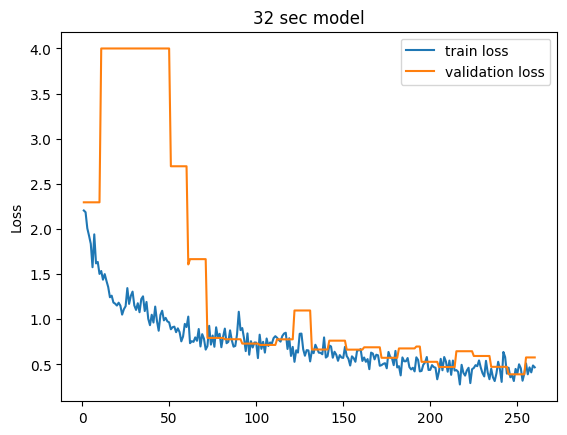

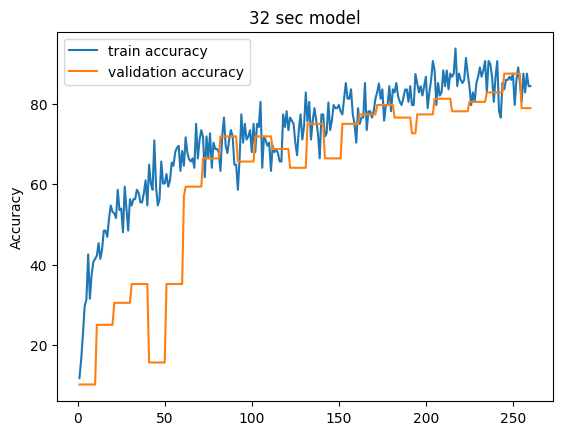

In [48]:
import numpy as np
import matplotlib.pyplot as plt
# [loss.item(), accuracy, val_loss, val_accuracy]
s_size = 32
data = np.load("RESULTS resnet50 32.npy")
data2 = np.load("RESULTS resnet50 322.npy")
data3 = readFile("RESULTS resnet50 32 TXT")
data_32 = np.concatenate((data, data2, data3), axis=0)
epochs_model_32 = range(1, len(data_32) + 1)

train_loss_32 = data_32.T[0]
accuracy_32 = data_32.T[1]
val_loss_32 = data_32.T[2]
val_accuracy_32 = data_32.T[3]
val_loss_32[val_loss_32>4]=4



data_16 = readFile("RESULTS resnet50 16 TXT")


train_loss_16 = data_16.T[0]
accuracy_16 = data_16.T[1]
val_loss_16 = smooth(data_16.T[2],20)
val_accuracy_16 = data_16.T[3]
val_loss_16[val_loss_16>4]=4

epochs_model_16 = range(1, len(data_16) + 1)
epochs_model_16_smooth = range(1, len(val_loss_16) + 1)

print(data_32.shape)

plt.plot(epochs_model_32, train_loss_32, label = "train loss")
plt.plot(epochs_model_32,val_loss_32, label = "validation loss")

plt.title(f"{s_size} sec model")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"plots\\loss {s_size} sec model")
plt.show()

plt.plot(epochs_model_32, accuracy_32, label = "train accuracy")
plt.plot(epochs_model_32, val_accuracy_32, label = "validation accuracy")

plt.ylabel("Accuracy")
plt.title(f"{s_size} sec model")
plt.legend()
plt.savefig(f"plots\\acc {s_size} sec model")
plt.show()

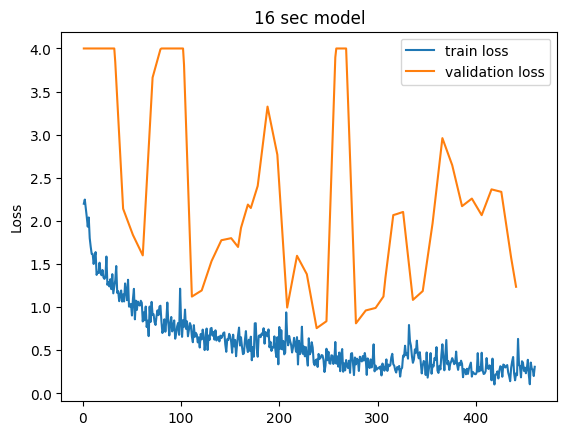

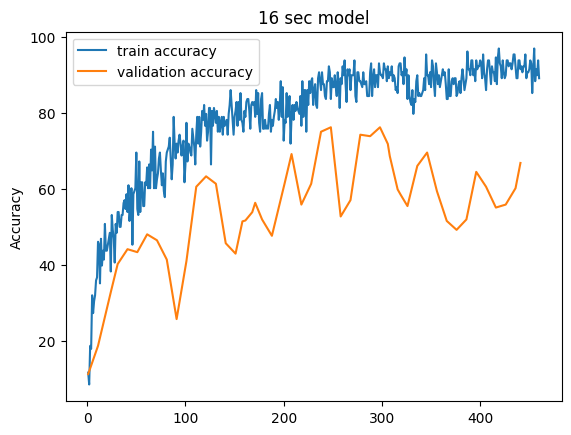

In [49]:
data_16 = readFile("RESULTS resnet50 16 TXT")
s_size = 16

train_loss_16 = data_16.T[0]
accuracy_16 = data_16.T[1]
val_loss_16 = smooth(data_16.T[2],20)
val_accuracy_16 = smooth(data_16.T[3], 20)
val_loss_16[val_loss_16>4]=4

epochs_model_16 = range(1, len(data_16) + 1)
epochs_model_16_smooth = range(1, len(val_loss_16) + 1)


plt.plot(epochs_model_16, train_loss_16, label = "train loss")
plt.plot(epochs_model_16_smooth,val_loss_16, label = "validation loss")

plt.title(f"{s_size} sec model")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"plots\\loss {s_size} sec model")
plt.show()

plt.plot(epochs_model_16, accuracy_16, label = "train accuracy")
plt.plot(epochs_model_16_smooth, val_accuracy_16, label = "validation accuracy")

plt.ylabel("Accuracy")
plt.title(f"{s_size} sec model")
plt.legend()
plt.savefig(f"plots\\acc {s_size} sec model")
plt.show()

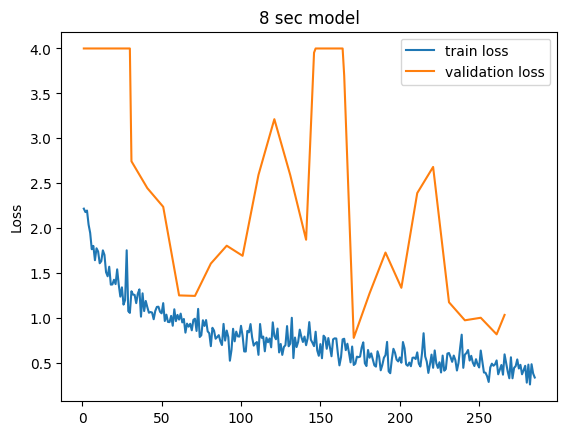

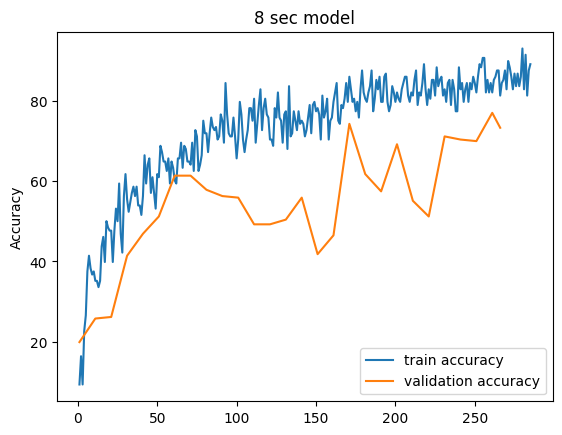

In [50]:
data_16 = readFile("RESULTS resnet50 8 TXT")
s_size = 8

train_loss_16 = data_16.T[0]
accuracy_16 = data_16.T[1]
val_loss_16 = smooth(data_16.T[2],20)
val_accuracy_16 = smooth(data_16.T[3], 20)
val_loss_16[val_loss_16>4]=4

epochs_model_16 = range(1, len(data_16) + 1)
epochs_model_16_smooth = range(1, len(val_loss_16) + 1)


plt.plot(epochs_model_16, train_loss_16, label = "train loss")
plt.plot(epochs_model_16_smooth,val_loss_16, label = "validation loss")

plt.title(f"{s_size} sec model")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"plots\\loss {s_size} sec model")
plt.show()

plt.plot(epochs_model_16, accuracy_16, label = "train accuracy")
plt.plot(epochs_model_16_smooth, val_accuracy_16, label = "validation accuracy")

plt.ylabel("Accuracy")
plt.title(f"{s_size} sec model")
plt.legend()
plt.savefig(f"plots\\acc {s_size} sec model")
plt.show()


plotting model_resnet50
plotting model_resnet50_8
plotting model_resnet50_16


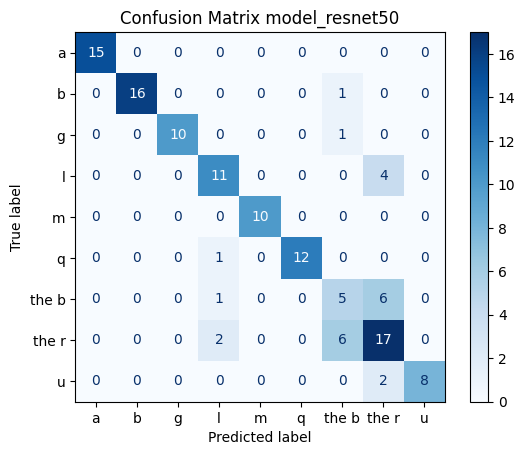

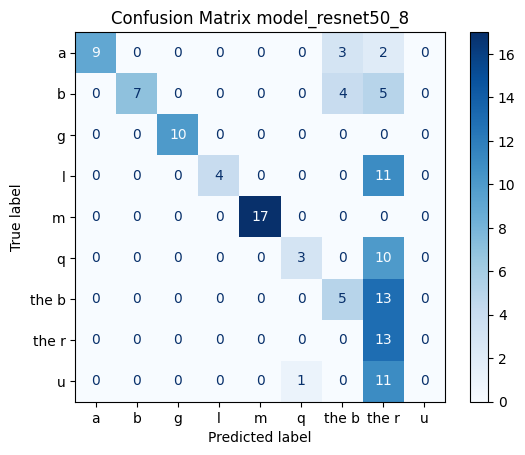

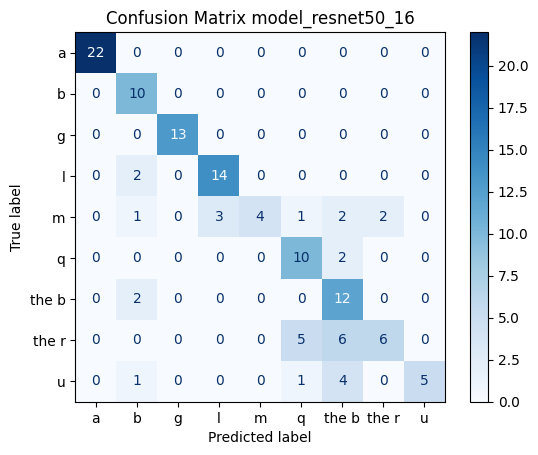

In [61]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def calculate_confusion_matrix(model, dataloader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names, title):
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix {title}')
    #plt.show()
    plt.savefig(f"plots\\{title} sec segment model")


models = {
    'model_resnet50':32,
    'model_resnet50_8':8,
    'model_resnet50_16':16
}
#class_names = ["abba", "bob dylan", "gucci", "led zeppelin" , "mozart" , "queen", "the beatles", "the rolling stones" , "u2"]
class_names = ["a", "b", "g", "l" , "m" , "q", "the b", "the r" , "u"]
for m in models.keys():
    print(f"plotting {m}")
    all_preds = []
    all_labels = []

    path = f"models\\{m}"
    m_loaded = torch.load(path, weights_only=False)
    validation_set_x, validation_set_labels = generate_random_set_MEMORY_EFFICIENT(BATCH_SIZE, models[m], test_dataset, folder="songs test")
        #validation_set_x, validation_set_labels = generate_random_set_TIME_EFFICIENT(BATCH_SIZE, SEGMENT_SIZE, test_dataset)
    model.eval()
    with torch.no_grad():
        val_outputs = m_loaded(validation_set_x)
        _, preds = torch.max(val_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(validation_set_labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, m)
    


# Example usage:
# Replace `model`, `dataloader`, and `class_names` with your own variables
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# cm = calculate_confusion_matrix(model, dataloader, device)
# class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names
# plot_confusion_matrix(cm, class_names)


In [57]:
models = {
    'model_resnet50':32,
    'model_resnet50_8':8,
    'model_resnet50_16':16
}
for m in models.keys():
    print(m)
    print(models[m])

model_resnet50
32
model_resnet50_8
8
model_resnet50_16
16
